Imports

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from transformers import RobertaTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/NLP_Project')

%cd /content/drive/My Drive/NLP_Project

import data_loader

Mounted at /content/drive
/content/drive/My Drive/NLP_Ex4


In [ ]:
from NLP_Project import *

In [ ]:
SEQ_LEN = 52
W2V_EMBEDDING_DIM = 300
HIDDEN_DIM = 100
NUM_LAYERS = 2

ONEHOT_AVERAGE = "onehot_average"
W2V_AVERAGE = "w2v_average"
W2V_SEQUENCE = "w2v_sequence"
RAW_TEXT = "raw_text"

TRAIN = "train"
VAL = "val"
TEST = "test"

In [ ]:
# Tokenizing data

def tokenize_data(sentences, labels, tokenizer, max_length=128):
    """
    Tokenizes the dataset using the provided tokenizer.
    :param sentences: List of sentences to tokenize.
    :param labels: Corresponding labels for the sentences.
    :param tokenizer: Hugging Face tokenizer instance.
    :param max_length: Maximum sequence length.
    :return: Tokenized dataset as a PyTorch TensorDataset.
    """
    encodings = tokenizer(sentences, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    encodings['labels'] = torch.tensor(labels)
    return torch.utils.data.TensorDataset(encodings['input_ids'], encodings['attention_mask'], encodings['labels'])

In [ ]:
def load_word2vec():
    """ Load Word2Vec Vectors
        Return:
            wv_from_bin: All 3 million embeddings, each lengh 300
    """
    import gensim.downloader as api
    wv_from_bin = api.load("word2vec-google-news-300")
    vocab = list(wv_from_bin.key_to_index.keys())
    print(wv_from_bin.key_to_index[vocab[0]])
    print("Loaded vocab size %i" % len(vocab))
    return wv_from_bin


def create_or_load_slim_w2v(words_list, cache_w2v=False):
    """
    returns word2vec dict only for words which appear in the dataset.
    :param words_list: list of words to use for the w2v dict
    :param cache_w2v: whether to save locally the small w2v dictionary
    :return: dictionary which maps the known words to their vectors
    """
    w2v_path = "w2v_dict.pkl"
    if not os.path.exists(w2v_path):
        full_w2v = load_word2vec()
        w2v_emb_dict = {k: full_w2v[k] for k in words_list if k in full_w2v}
        if cache_w2v:
            save_pickle(w2v_emb_dict, w2v_path)
    else:
        w2v_emb_dict = load_pickle(w2v_path)
    return w2v_emb_dict


def get_w2v_average(sent, word_to_vec, embedding_dim):
    """
    This method gets a sentence and returns the average word embedding of the words consisting
    the sentence.
    :param sent: the sentence object
    :param word_to_vec: a dictionary mapping words to their vector embeddings
    :param embedding_dim: the dimension of the word embedding vectors
    :return The average embedding vector as numpy ndarray.
    """
    # Extract tokens from the Sentence object
    tokens = sent.text  # 'text' is a list of tokens in the Sentence object

    # Collect embeddings for tokens present in word_to_vec
    embeddings = [word_to_vec[word] for word in tokens if word in word_to_vec]

    # If no embeddings were found, return a zero vector
    if not embeddings:
        return np.zeros(embedding_dim, dtype=np.float32)

    # Compute and return the average of the embeddings
    return np.mean(embeddings, axis=0)


def get_one_hot(size, ind):
    """
    this method returns a one-hot vector of the given size, where the 1 is placed in the ind entry.
    :param size: the size of the vector
    :param ind: the entry index to turn to 1
    :return: numpy ndarray which represents the one-hot vector
    """
    one_hot = np.zeros(size, dtype=np.float32)
    one_hot[ind] = 1.0
    return one_hot


def average_one_hots(sent, word_to_ind):
    """
    this method gets a sentence, and a mapping between words to indices, and returns the average
    one-hot embedding of the tokens in the sentence.
    :param sent: a sentence object.
    :param word_to_ind: a mapping between words to indices
    :return:
    """
    # Extract tokens directly from the Sentence object
    tokens = sent.text  # 'text' is a list of tokens in the Sentence object

    vocab_size = len(word_to_ind)
    sentence_vectors = [
        get_one_hot(vocab_size, word_to_ind[word])
        for word in tokens if word in word_to_ind
    ]

    # Handle cases where no tokens in the sentence map to the vocabulary
    if not sentence_vectors:
        return np.zeros(vocab_size, dtype=np.float32)

    # Return the average one-hot embedding
    return np.mean(sentence_vectors, axis=0)


def get_word_to_ind(words_list):
    """
    this function gets a list of words, and returns a mapping between
    words to their index.
    :param words_list: a list of words
    :return: the dictionary mapping words to the index
    """
    return {word: idx for idx, word in enumerate(words_list)}


def sentence_to_embedding(sent, word_to_vec, seq_len, embedding_dim=300):
    """
    Converts a sentence to a fixed-length sequence of word embeddings.
    """
    tokens = sent.text  # Extract tokens from the sentence object
    embeddings = [
        word_to_vec.get(token, np.zeros(embedding_dim, dtype=np.float32))
        for token in tokens[:seq_len]
    ]

    # Add padding for sentences shorter than seq_len
    if len(embeddings) < seq_len:
        padding = [np.zeros(embedding_dim, dtype=np.float32)] * (seq_len - len(embeddings))
        embeddings.extend(padding)

    return np.array(embeddings, dtype=np.float32)


class OnlineDataset(Dataset):
    """
    A pytorch dataset which generates model inputs on the fly from sentences of SentimentTreeBank
    """

    def __init__(self, sent_data, sent_func, sent_func_kwargs):
        """
        :param sent_data: list of sentences from SentimentTreeBank
        :param sent_func: Function which converts a sentence to an input datapoint
        :param sent_func_kwargs: fixed keyword arguments for the state_func
        """
        self.data = sent_data
        self.sent_func = sent_func
        self.sent_func_kwargs = sent_func_kwargs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sent = self.data[idx]
        sent_emb = self.sent_func(sent, **self.sent_func_kwargs)
        sent_label = sent.sentiment_class
        return sent_emb, sent_label


class DataManager():
    """
    Utility class for handling all data management task. Can be used to get iterators for training and
    evaluation.
    """

    def __init__(self, data_type=ONEHOT_AVERAGE, use_sub_phrases=True, dataset_path="/content/drive/My Drive/NLP_Project/stanfordSentimentTreebank", batch_size=50,
                 embedding_dim=None, tokinizer=None, max_seq_length=128,):
        """
        builds the data manager used for training and evaluation.
        :param data_type: one of ONEHOT_AVERAGE, W2V_AVERAGE and W2V_SEQUENCE
        :param use_sub_phrases: if true, training data will include all sub-phrases plus the full sentences
        :param dataset_path: path to the dataset directory
        :param batch_size: number of examples per batch
        :param embedding_dim: relevant only for the W2V data types.
        """

        # load the dataset
        self.sentiment_dataset = data_loader.SentimentTreeBank(dataset_path, split_words=True)
        # map data splits to sentences lists
        self.sentences = {}
        if use_sub_phrases:
            self.sentences[TRAIN] = self.sentiment_dataset.get_train_set_phrases()
        else:
            self.sentences[TRAIN] = self.sentiment_dataset.get_train_set()

        self.sentences[VAL] = self.sentiment_dataset.get_validation_set()
        self.sentences[TEST] = self.sentiment_dataset.get_test_set()

        # map data splits to sentence input preperation functions
        words_list = list(self.sentiment_dataset.get_word_counts().keys())
        if data_type == ONEHOT_AVERAGE:
            self.sent_func = average_one_hots
            self.sent_func_kwargs = {"word_to_ind": get_word_to_ind(words_list)}
        elif data_type == W2V_SEQUENCE:
            self.sent_func = sentence_to_embedding

            self.sent_func_kwargs = {"seq_len": SEQ_LEN,
                                     "word_to_vec": create_or_load_slim_w2v(words_list),
                                     "embedding_dim": embedding_dim
                                     }
        elif data_type == W2V_AVERAGE:
            self.sent_func = get_w2v_average
            words_list = list(self.sentiment_dataset.get_word_counts().keys())
            self.sent_func_kwargs = {"word_to_vec": create_or_load_slim_w2v(words_list),
                                     "embedding_dim": embedding_dim
                                     }
        #
        elif data_type == "RAW_TEXT":
            self.sent_func = lambda sent: " ".join(sent.text)
            self.sent_func_kwargs = {}
        #
        else:
            raise ValueError("invalid data_type: {}".format(data_type))
        # map data splits to torch datasets and iterators
        self.torch_datasets = {k: OnlineDataset(sentences, self.sent_func, self.sent_func_kwargs) for
                               k, sentences in self.sentences.items()}
        self.torch_iterators = {k: DataLoader(dataset, batch_size=batch_size, shuffle=k == TRAIN)
                                for k, dataset in self.torch_datasets.items()}

    def get_torch_iterator(self, data_subset=TRAIN):
        """
        :param data_subset: one of TRAIN VAL and TEST
        :return: torch batches iterator for this part of the datset
        """
        return self.torch_iterators[data_subset]

    def get_labels(self, data_subset=TRAIN):
        """
        :param data_subset: one of TRAIN VAL and TEST
        :return: numpy array with the labels of the requested part of the datset in the same order of the
        examples.
        """
        return np.array([sent.sentiment_class for sent in self.sentences[data_subset]])

    def get_input_shape(self):
        """
        :return: the shape of a single example from this dataset (only of x, ignoring y the label).
        """
        return self.torch_datasets[TRAIN][0][0].shape

In [ ]:
# Training function

def train_transformer(model, train_loader, val_loader, lr, weight_decay, n_epochs, device):
    """
    Train the transformer model.
    """
    criterion = CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    num_training_steps = len(train_loader) * n_epochs
    lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

    model.to(device)
    train_loss_values, val_loss_values = [], []
    train_accuracy_values, val_accuracy_values = [], []

    for epoch in range(n_epochs):
        model.train()
        total_train_loss, correct_train_preds, total_train_examples = 0, 0, 0

        for batch in tqdm.tqdm(train_loader, desc=f"Epoch {epoch + 1}/{n_epochs} - Training"):
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            labels = labels.long()
            optimizer.zero_grad()

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

            total_train_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct_train_preds += (preds == labels).sum().item()
            total_train_examples += labels.size(0)

        train_loss_values.append(total_train_loss / len(train_loader))
        train_accuracy_values.append(correct_train_preds / total_train_examples)

        model.eval()
        total_val_loss, correct_val_preds, total_val_examples = 0, 0, 0

        with torch.no_grad():
            for batch in tqdm.tqdm(val_loader, desc=f"Epoch {epoch + 1}/{n_epochs} - Validation"):
                input_ids, attention_mask, labels = [x.to(device) for x in batch]
                labels = labels.long()
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                loss = criterion(logits, labels)

                total_val_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                correct_val_preds += (preds == labels).sum().item()
                total_val_examples += labels.size(0)

        val_loss_values.append(total_val_loss / len(val_loader))
        val_accuracy_values.append(correct_val_preds / total_val_examples)

    return train_loss_values, val_loss_values, train_accuracy_values, val_accuracy_values

In [ ]:
# Evaluation function

def evaluate(model, test_loader, device):
    """
    Evaluate the model on a dataset.
    """
    model.eval()
    criterion = CrossEntropyLoss()
    total_loss, correct_preds, total_examples = 0, 0, 0

    with torch.no_grad():
        for batch in tqdm.tqdm(test_loader, desc="Evaluating"):
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            labels = labels.long()
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct_preds += (preds == labels).sum().item()
            total_examples += labels.size(0)

    accuracy = correct_preds / total_examples
    return total_loss / len(test_loader), accuracy

In [ ]:
# Plotting function

def plot_metrics(train_metric, val_metric, metric_name, save_path):
    """
    Plot and save training/validation metrics.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(train_metric) + 1), train_metric, label=f"Train {metric_name}")
    plt.plot(range(1, len(val_metric) + 1), val_metric, label=f"Validation {metric_name}")
    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.title(f"Train and Validation {metric_name}")
    plt.legend()
    plt.grid()
    plt.savefig(save_path)
    plt.show()

In [ ]:
def transformer_classification():
    """
    Train and evaluate a transformer for sentiment analysis.
    """
    # Load tokenizer and model
    tokenizer = RobertaTokenizer.from_pretrained("distilroberta-base")
    model = AutoModelForSequenceClassification.from_pretrained("distilroberta-base", num_labels=2)

    # Data Preparation
    data_manager = DataManager(
        data_type="RAW_TEXT", use_sub_phrases=True, dataset_path="stanfordSentimentTreebank", batch_size=64
    )

    train_sentences = [" ".join(sent.text) for sent in data_manager.sentences[TRAIN]]
    val_sentences = [" ".join(sent.text) for sent in data_manager.sentences[VAL]]
    test_sentences = [" ".join(sent.text) for sent in data_manager.sentences[TEST]]

    train_labels = data_manager.get_labels(TRAIN).tolist()
    val_labels = data_manager.get_labels(VAL).tolist()
    test_labels = data_manager.get_labels(TEST).tolist()

    train_data = tokenize_data(train_sentences, train_labels, tokenizer)
    val_data = tokenize_data(val_sentences, val_labels, tokenizer)
    test_data = tokenize_data(test_sentences, test_labels, tokenizer)

    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=64)
    test_loader = DataLoader(test_data, batch_size=64)

    # Training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loss, val_loss, train_acc, val_acc = train_transformer(
        model, train_loader, val_loader, lr=1e-5, weight_decay=0, n_epochs=2, device=device
    )

    # Evaluation
    test_loss, test_accuracy = evaluate(model, test_loader, device)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Plot metrics
    plot_metrics(train_loss, val_loss, "Loss", "transformer_loss_plot.png")
    plot_metrics(train_acc, val_acc, "Accuracy", "transformer_accuracy_plot.png")

    # Evaluate on special subsets
    special_subsets = {
    "Negated Polarity": data_loader.get_negated_polarity_examples(
        data_manager.sentences[TEST]),
    "Rare Words": data_loader.get_rare_words_examples(
        data_manager.sentences[TEST],
        data_manager.sentiment_dataset),
    }
    for subset_name, subset_indices in special_subsets.items():
        subset_data = torch.utils.data.Subset(data_manager.torch_datasets[TEST], subset_indices)
        subset_loader = DataLoader(subset_data, batch_size=64, shuffle=False)

        model.eval()
        correct_preds, total_examples = 0, 0

        with torch.no_grad():
            for batch in tqdm.tqdm(subset_loader, desc="Evaluating Subset"):
                # Unpack batch structure
                sentences, labels = batch
                # Tokenize sentences
                encodings = tokenizer(list(sentences), truncation=True, padding=True, max_length=128,
                                      return_tensors="pt")
                input_ids = encodings["input_ids"].to(device)
                attention_mask = encodings["attention_mask"].to(device)
                labels = labels.to(device).long()  # Convert labels to the correct device and data type

                # Model predictions
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)

                # Compute accuracy
                correct_preds += (preds == labels).sum().item()
                total_examples += labels.size(0)
        accuracy_score = correct_preds / total_examples
        print(f"{subset_name} - Accuracy: {accuracy_score:.4f}")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Evaluating: 100%|██████████| 16/16 [00:01<00:00, 10.52it/s]


Test Loss: 0.1905
Test Accuracy: 0.9085


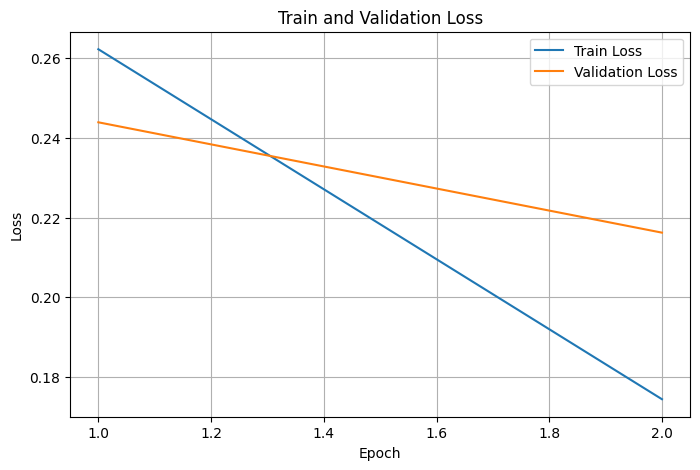

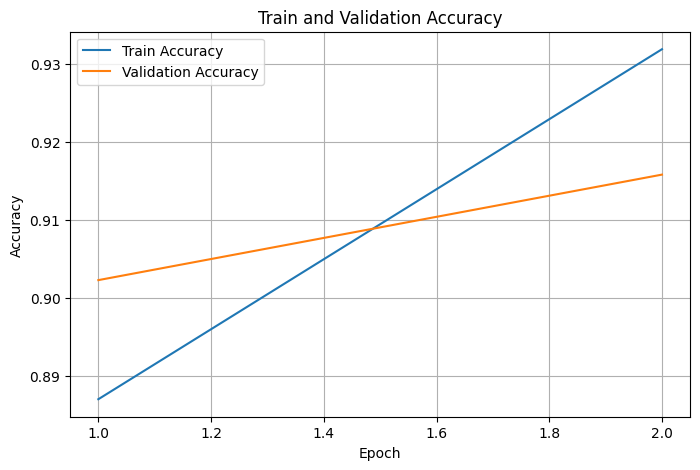

Evaluating Subset: 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]


Negated Polarity - Accuracy: 0.8226


Evaluating Subset: 100%|██████████| 1/1 [00:00<00:00, 13.74it/s]


Rare Words - Accuracy: 0.8600


In [ ]:
if __name__ == "__main__":
    transformer_classification()